# Gradient norm 2

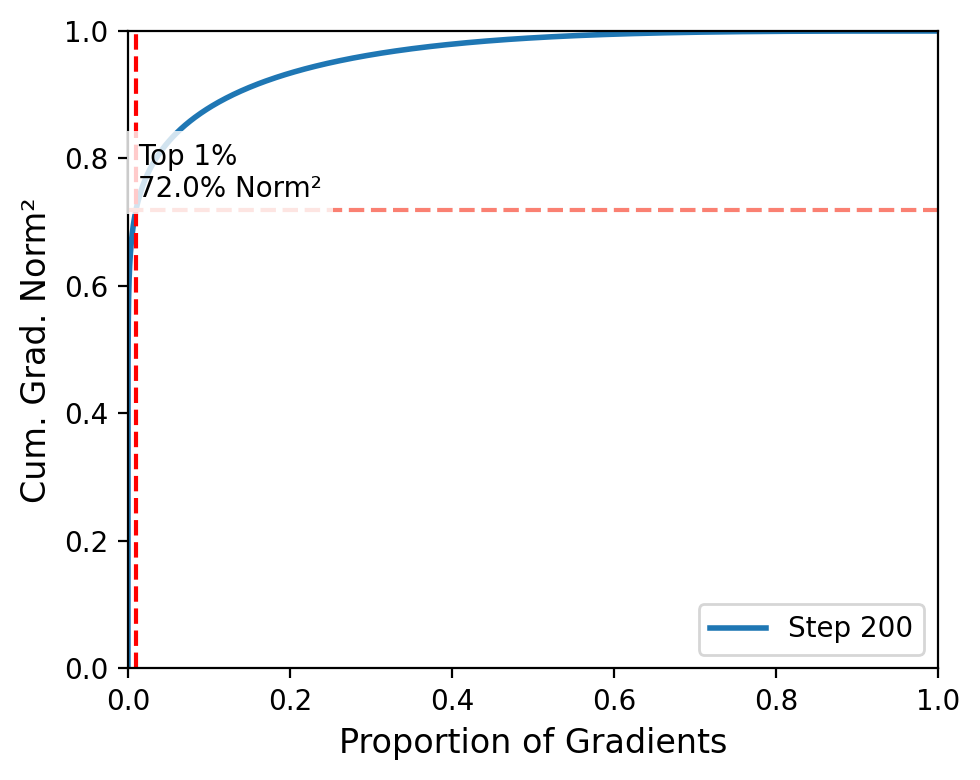

[OK] N=357854208 elements (sample_frac=1.0) | top 1% captures 71.96% of total g²
Saved figure to: /pscratch/sd/l/lsx/runs/Qwen_Qwen2.5-0.5B-tatsu-lab_alpaca/grad_dump/step000200/grad_curve_step000200.png


In [1]:
import os, math, gc, warnings
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

# ==== Config ====
BASE_DIR = "/pscratch/sd/l/lsx/runs/Qwen_Qwen2.5-0.5B-tatsu-lab_alpaca/grad_dump"
INDEX_CSV = os.path.join(BASE_DIR, "index.csv")
GLOBAL_STEP = 200                 # e.g., 700 for step000700
SAMPLE_FRAC = 1.0                 # set < 1.0 (e.g., 0.25) if you hit RAM issues
SAVE_PATH = os.path.join(BASE_DIR, f"{BASE_DIR}/step{GLOBAL_STEP:06d}/grad_curve_step{GLOBAL_STEP:06d}.png")

# ==== Helpers ====
def _load_any_tensor(path: str) -> torch.Tensor:
    """
    Load a tensor from path (supports torch .pt/.pth/.bin and numpy .npy/.npz).
    Returns a CPU float32 tensor. Assumes the file stores a tensor or an array-like.
    """
    ext = os.path.splitext(path)[1].lower()
    try:
        if ext in [".pt", ".pth", ".bin"]:
            obj = torch.load(path, map_location="cpu")
            if isinstance(obj, torch.Tensor):
                t = obj
            elif isinstance(obj, dict) and "tensor" in obj:
                t = obj["tensor"]
            else:
                # Try to pull the first tensor-shaped thing
                if isinstance(obj, dict):
                    for v in obj.values():
                        if isinstance(v, torch.Tensor):
                            t = v; break
                    else:
                        raise ValueError(f"No tensor found in {path}")
                else:
                    raise ValueError(f"Unsupported torch object in {path}: {type(obj)}")
            return t.detach().to(dtype=torch.float32, device="cpu")
        elif ext == ".npy":
            arr = np.load(path, allow_pickle=False)
            return torch.from_numpy(np.array(arr, dtype=np.float32))
        elif ext == ".npz":
            npz = np.load(path, allow_pickle=False)
            # take the first array
            key = list(npz.keys())[0]
            return torch.from_numpy(np.array(npz[key], dtype=np.float32))
        else:
            raise ValueError(f"Unsupported file extension: {ext}")
    except Exception as e:
        raise RuntimeError(f"Failed to load tensor from {path}: {e}")

def _g2_flat_from_file(path: str, sample_frac: float) -> np.ndarray:
    """
    Load a gradient tensor file -> return a 1D numpy array of squared magnitudes (g^2).
    Optionally uniform-subsample elements to reduce memory.
    """
    t = _load_any_tensor(path)
    t = t.reshape(-1)
    if sample_frac < 1.0:
        # uniform subsampling without replacement
        n = t.numel()
        k = max(1, int(math.ceil(n * sample_frac)))
        idx = torch.randperm(n)[:k]
        t = t[idx]
    g2 = (t**2).to(dtype=torch.float32).cpu().numpy()
    del t
    gc.collect()
    return g2

# ==== Load index & collect files for this global_step ====:A/global
df = pd.read_csv(INDEX_CSV)
if "global_step" not in df.columns or "file" not in df.columns:
    raise ValueError("index.csv must contain columns 'global_step' and 'file'.")

rows = df[df["global_step"] == GLOBAL_STEP]
if rows.empty:
    raise ValueError(f"No entries for global_step={GLOBAL_STEP} in {INDEX_CSV}")

# The 'file' column is expected to be relative to BASE_DIR (e.g., "step000700/layer...pt")
file_paths = [os.path.join(BASE_DIR, f) for f in rows["file"].tolist()]

# ==== Aggregate all g^2 and sort descending ====
chunks = []
total_elems = 0
for p in file_paths:
    if not os.path.isfile(p):
        warnings.warn(f"Missing file: {p}")
        continue
    g2 = _g2_flat_from_file(p, SAMPLE_FRAC)
    chunks.append(g2)
    total_elems += g2.size

if total_elems == 0:
    raise RuntimeError("No gradients loaded (all files missing or empty).")

g2_all = np.concatenate(chunks, axis=0)
del chunks
gc.collect()

# Sort by magnitude^2 descending
order = np.argsort(g2_all)[::-1]
g2_sorted = g2_all[order]
del g2_all, order
gc.collect()

# ==== Build the curve ====
N = g2_sorted.size
x = (np.arange(1, N + 1, dtype=np.float64)) / float(N)    # proportion of gradients
cum = np.cumsum(g2_sorted, dtype=np.float64)
total = cum[-1]
y = cum / total                                           # proportion of cumulative grad norm^2

# Value captured by top 1%
k_1pct = max(1, int(math.ceil(0.01 * N)))
y_at_1pct = y[k_1pct - 1]

# ==== Plot ====
fig, ax = plt.subplots(figsize=(5.0, 4.0), dpi=200)
ax.plot(x, y, linewidth=2)

# Annotations like ZenFlow Fig. 4
ax.axvline(0.01, linestyle="--", linewidth=1.5, color="red")
ax.axhline(y_at_1pct, linestyle="--", linewidth=1.5, color="salmon")

ax.set_xlabel("Proportion of Gradients", fontsize=12)
ax.set_ylabel("Cum. Grad. Norm²", fontsize=12)
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.0)
ax.grid(False)

lbl = f"Top 1%\n{y_at_1pct*100:.1f}% Norm²"
ax.legend([f"Step {GLOBAL_STEP}"], loc="lower right", frameon=True)
# Add a small text box showing the two dashed guides
ax.text(0.012, y_at_1pct + 0.02, lbl, fontsize=10, bbox=dict(facecolor="white", alpha=0.8, edgecolor="none"))

plt.tight_layout()
plt.savefig(SAVE_PATH, bbox_inches="tight")
plt.show()

print(f"[OK] N={N} elements (sample_frac={SAMPLE_FRAC}) | top 1% captures {y_at_1pct*100:.2f}% of total g²")
print(f"Saved figure to: {SAVE_PATH}")
